In [281]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap
from sklearn import svm
from sklearn.datasets import make_blobs, make_classification, make_moons
%matplotlib inline

In [235]:
import seaborn as sns
sns.set(color_codes=True)
sns.set_style('whitegrid')
sns.set_context('paper',font_scale=2)
%config InlineBackend.print_figure_kwargs = {'bbox_inches':None}


# Some simple thought experiments

Consider a situation where you are trying to learn a system that can label if an individual will commit a crime (label = `yes` or +1) or not commit a crime (label=`no` or -1), if granted bail. For simplicity, let us assume that we are only using two features as inputs, `num_past_offenses` (denoted as $x_1$) and `age` (denoted as $x_2$).

Let us first look at **all** of the data. Of course, this is all made up.

In [110]:
X = np.vstack([np.random.uniform(-1,1,500),np.random.uniform(-1,1,500)]).T

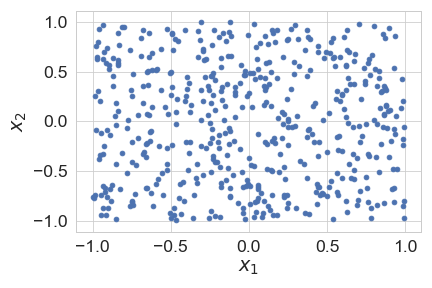

In [111]:
# let us assume this is all the data
plt.scatter(X[:, 0], X[:, 1])
plt.xlabel('$x_1$')
plt.ylabel('$x_2$')
plt.tight_layout()

Now we add the label (+1 or -1). Let us assume that the true hypothesis (or the decision boundary) is a line with the following equation:

$$
w_0 + w_1x_1 + w_2x_2 = 0
$$

where $w_0 = 0, w_1 = 1, w_2 = 1$. Thus, the decision boundary becomes:

$$
x_1 + x_2 = 0
$$

Now of course, to draw the line, I will have to express it in the $y = mx + c$ format:

$$
x_2 = -x_1
$$


In [112]:
# get the labels
X_i = np.hstack([np.ones((X.shape[0],1)),X])
w = np.array([[0],[1],[1]])
y = np.array((np.dot(X_i,w) > 0),dtype='int')
y[y == 0] = -1

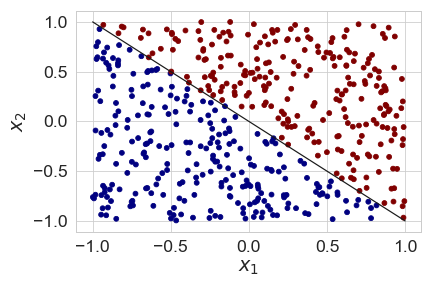

In [113]:
# let us assume this is all the data
plt.scatter(X[:, 0], X[:, 1],c=y.flatten(), s=24, cmap='jet')
plt.xlabel('$x_1$')
plt.ylabel('$x_2$')
plt.plot(np.linspace(-1,1,10), -np.linspace(-1,1,10), '-k')
plt.tight_layout()

## Training phase
During training, we are given a sample of the data

In [116]:
traininds = np.random.permutation(X.shape[0])[0:100]
Xtrain = X[traininds,:]
ytrain = y[traininds,:]

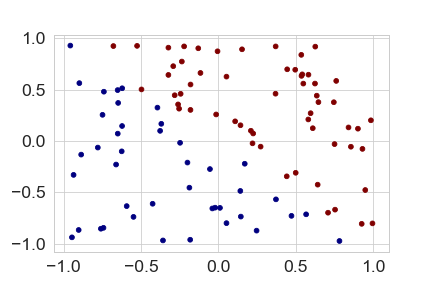

In [117]:
plt.scatter(Xtrain[:, 0], Xtrain[:, 1],c=ytrain.flatten(), cmap='jet')

### which line to choose?

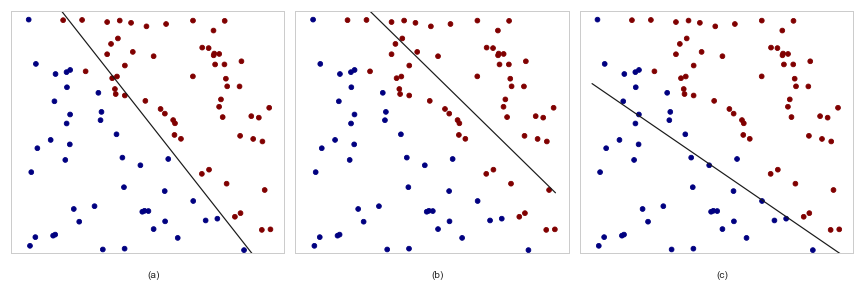

In [126]:
fig, ax = plt.subplots(1, 3, figsize=(12, 4))
ax[0].scatter(Xtrain[:, 0], Xtrain[:, 1],c=ytrain.flatten(), cmap='jet')
ax[0].set_xticks([])
ax[0].set_yticks([])
ax[0].text(0,-1.2,'(a)')
ax[0].plot(np.linspace(-1,1,10), -1.3*np.linspace(-1,1,10)+0.1, '-k')
ax[0].set_ylim([-1,1])

ax[1].scatter(Xtrain[:, 0], Xtrain[:, 1],c=ytrain.flatten(), cmap='jet')
ax[1].set_xticks([])
ax[1].set_yticks([])
ax[1].text(0,-1.2,'(b)')
ax[1].plot(np.linspace(-1,1,10), -np.linspace(-1,1,10)+0.5, '-k')
ax[1].set_ylim([-1,1])


ax[2].scatter(Xtrain[:, 0], Xtrain[:, 1],c=ytrain.flatten(), cmap='jet')
ax[2].set_xticks([])
ax[2].set_yticks([])
ax[2].text(0,-1.2,'(c)')
ax[2].plot(np.linspace(-1,1,10), -0.7*np.linspace(-1,1,10)-0.3, '-k')
ax[2].set_ylim([-1,1])


plt.tight_layout()

### How about this?

Let us assume that the training data is not *uniformly sampled*

In [154]:
# get the labels
X_i = np.hstack([np.ones((X.shape[0],1)),X])
z_hat = np.abs(np.dot(X_i,w))
sel_inds = np.where(z_hat > 0.3)[0]
X1 = X[sel_inds,:]
y1 = y[sel_inds]

traininds = np.random.permutation(X1.shape[0])[0:100]
Xtrain1 = X1[traininds,:]
ytrain = y1[traininds,:]

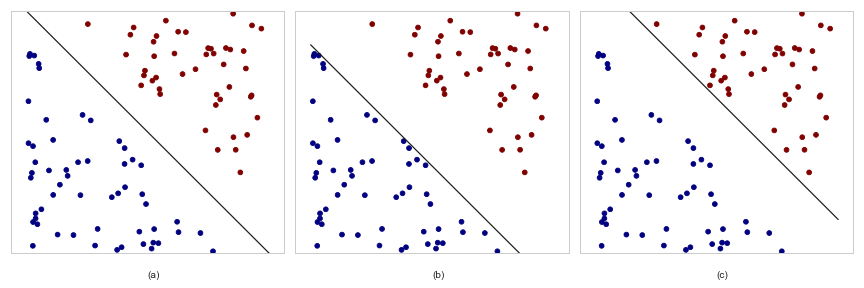

In [156]:
alphaval=0.0
fig, ax = plt.subplots(1, 3, figsize=(12, 4))
ax[0].scatter(Xtrain1[:, 0], Xtrain1[:, 1],c=ytrain1.flatten(), cmap='jet')
ax[0].scatter(X[:,0],X[:,1],alpha=alphaval,c='k')
ax[0].set_xticks([])
ax[0].set_yticks([])
ax[0].text(0,-1.2,'(a)')
ax[0].plot(np.linspace(-1,1,10), -np.linspace(-1,1,10), '-k')
ax[0].set_ylim([-1,1])

ax[1].scatter(Xtrain1[:, 0], Xtrain1[:, 1],c=ytrain1.flatten(), cmap='jet')
ax[1].scatter(X[:,0],X[:,1],alpha=alphaval,c='k')
ax[1].set_xticks([])
ax[1].set_yticks([])
ax[1].text(0,-1.2,'(b)')
ax[1].plot(np.linspace(-1,1,10), -np.linspace(-1,1,10)-0.28, '-k')
ax[1].set_ylim([-1,1])


ax[2].scatter(Xtrain1[:, 0], Xtrain1[:, 1],c=ytrain1.flatten(), cmap='jet')
ax[2].scatter(X[:,0],X[:,1],alpha=alphaval,c='k')
ax[2].set_xticks([])
ax[2].set_yticks([])
ax[2].text(0,-1.2,'(c)')
ax[2].plot(np.linspace(-1,1,10), -np.linspace(-1,1,10)+0.28, '-k')
ax[2].set_ylim([-1,1])


plt.tight_layout()

# Support Vector Machines

### Separable case

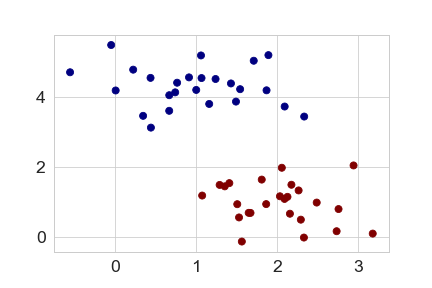

In [340]:
#checking margins
from sklearn.datasets.samples_generator import make_blobs
X, y = make_blobs(n_samples=50, centers=2,
                  random_state=0, cluster_std=0.60)
y[y==0] = -1
plt.scatter(X[:, 0], X[:, 1], c=y, s=50, cmap='jet');

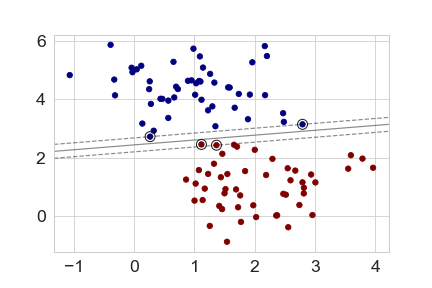

In [349]:
# fit the model
clf = svm.SVC(kernel='linear', C=10)
clf.fit(X, y)

plt.scatter(X[:, 0], X[:, 1], c=y, s=30, cmap='jet')

# plot the decision function
ax = plt.gca()
xlim = ax.get_xlim()
ylim = ax.get_ylim()

# create grid to evaluate model
xx = np.linspace(xlim[0], xlim[1], 30)
yy = np.linspace(ylim[0], ylim[1], 30)
YY, XX = np.meshgrid(yy, xx)
xy = np.vstack([XX.ravel(), YY.ravel()]).T
Z = clf.decision_function(xy).reshape(XX.shape)

# plot decision boundary and margins
ax.contour(XX, YY, Z, colors='k', levels=[-1, 0, 1], alpha=0.5,
           linestyles=['--', '-', '--'])
# plot support vectors
ax.scatter(clf.support_vectors_[:, 0], clf.support_vectors_[:, 1], s=100,
           linewidth=1, facecolors='none', edgecolors='k')
plt.show()

In [343]:
clf.dual_coef_

array([[-0.2672062, -0.7327938,  1.       ]])

In [344]:
clf.support_vectors_

array([[0.44359863, 3.11530945],
       [2.33812285, 3.43116792],
       [2.06156753, 1.96918596]])

In [206]:
clf.dual_coef_

array([[-0.2672062, -0.7327938,  1.       ]])

The `sklearn` implementation attaches the sign to the $\alpha$s

In [221]:
# calculating w
w = np.sum(clf.dual_coef_.T*clf.support_vectors_,axis=0)
print(w)

[ 0.22967329 -1.37758262]


In [222]:
clf.coef_

array([[ 0.22967329, -1.37758262]])

The key takeaway here is that while the dual optimization formulation of SVMs involves $N$ $\alpha$s, only a few are non-zero. These correspond to the training examples that lie on the hyper-plane, and are know as the **support vectors**.

### Non-separable Case

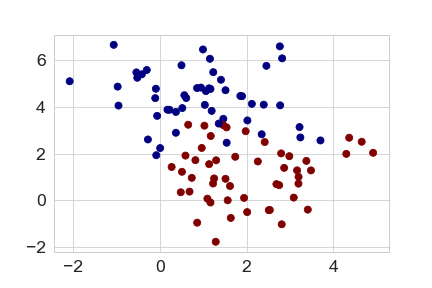

In [346]:
X, y = make_blobs(n_samples=100, centers=2,
                  random_state=0, cluster_std=1.2)
plt.scatter(X[:, 0], X[:, 1], c=y, s=50, cmap='jet');

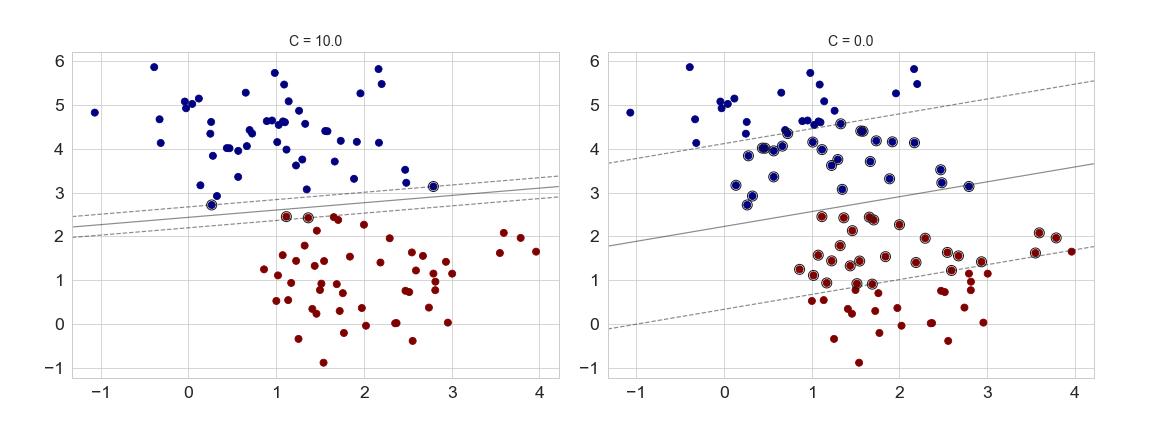

In [358]:
X, y = make_blobs(n_samples=100, centers=2,
                  random_state=0, cluster_std=0.8)

fig, ax = plt.subplots(1, 2, figsize=(16, 6))
fig.subplots_adjust(left=0.0625, right=0.95, wspace=0.1)

for axi, C in zip(ax, [10.0, 0.01]):
    clf = svm.SVC(kernel='linear', C=C)
    clf.fit(X, y)
    axi.scatter(X[:, 0], X[:, 1], c=y, s=50, cmap='jet')
    xlim = axi.get_xlim()
    ylim = axi.get_ylim()

    # create grid to evaluate model
    xx = np.linspace(xlim[0], xlim[1], 30)
    yy = np.linspace(ylim[0], ylim[1], 30)
    YY, XX = np.meshgrid(yy, xx)
    xy = np.vstack([XX.ravel(), YY.ravel()]).T
    Z = clf.decision_function(xy).reshape(XX.shape)

    # plot decision boundary and margins
    axi.contour(XX, YY, Z, colors='k', levels=[-1, 0, 1], alpha=0.5,
               linestyles=['--', '-', '--'])
    # plot support vectors
    axi.scatter(clf.support_vectors_[:, 0], clf.support_vectors_[:, 1], s=100,
               linewidth=1, facecolors='none', edgecolors='k')
    axi.set_title('C = {0:.1f}'.format(C), size=14)

# Bias vs. Variance
Consider the following experiment

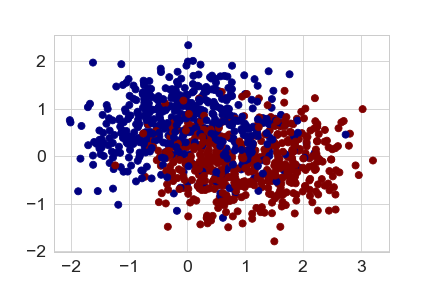

In [350]:
#X, y = make_blobs(n_samples=1000, centers=2,
#                  random_state=0, cluster_std=1.8)
X, y = make_moons(n_samples=1000,noise=0.5, random_state=0)
plt.scatter(X[:, 0], X[:, 1], c=y, s=50, cmap='jet');

We sample points from the above data set, and every time train a linear SVM classifier on the sample. Due to randomness, the trained model will be different. However, we want to study, if the model is more stable when C is high or low?

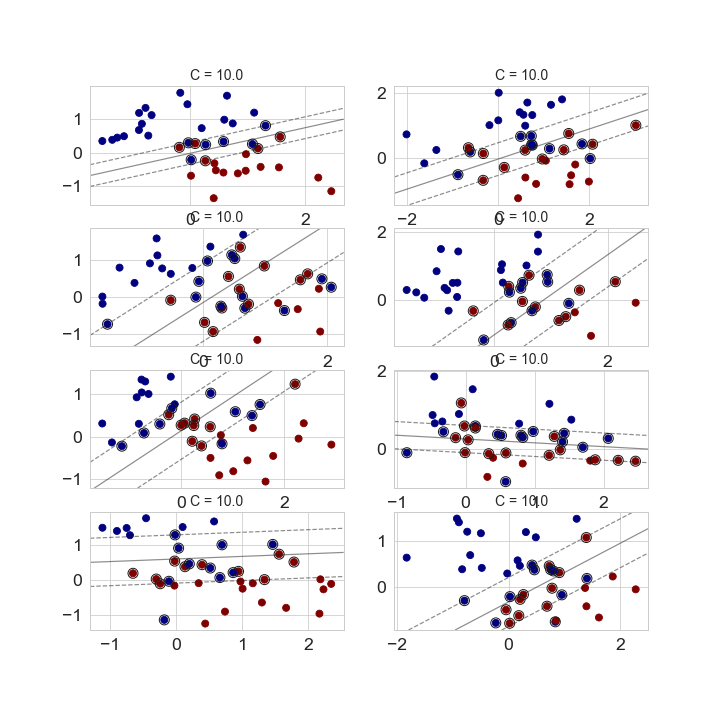

In [355]:
C = 10
fig, ax = plt.subplots(4, 2, figsize=(10, 10))
expind = 0
for i in range(4):
    for j in range(2):
        axi = ax[i,j]
        sampleinds = np.random.permutation(X.shape[0])[0:40]
        Xtrain,ytrain = X[sampleinds,:],y[sampleinds]

        clf = svm.SVC(kernel='linear', C=C)
        clf.fit(Xtrain, ytrain)
        axi.scatter(Xtrain[:, 0], Xtrain[:, 1], c=ytrain, s=50, cmap='jet')
        xlim = axi.get_xlim()
        ylim = axi.get_ylim()

        # create grid to evaluate model
        xx = np.linspace(xlim[0], xlim[1], 30)
        yy = np.linspace(ylim[0], ylim[1], 30)
        YY, XX = np.meshgrid(yy, xx)
        xy = np.vstack([XX.ravel(), YY.ravel()]).T
        Z = clf.decision_function(xy).reshape(XX.shape)

        # plot decision boundary and margins
        axi.contour(XX, YY, Z, colors='k', levels=[-1, 0, 1], alpha=0.5,
                   linestyles=['--', '-', '--'])
        # plot support vectors
        axi.scatter(clf.support_vectors_[:, 0], clf.support_vectors_[:, 1], s=100,
                   linewidth=1, facecolors='none', edgecolors='k')
        axi.set_title('C = {0:.1f}'.format(C), size=14)

In [356]:
var = []
for C in np.linspace(0.1,10,20):
    coefs = []
    for i in range(100):
        sampleinds = np.random.permutation(X.shape[0])[0:40]
        Xtrain,ytrain = X[sampleinds,:],y[sampleinds]

        clf = svm.SVC(kernel='linear', C=C)
        clf.fit(Xtrain, ytrain)
        coefs.append(np.array([clf.coef_[0,0],clf.coef_[0,1]]))
    var.append(np.sum(np.std(np.array(coefs),axis=0)))


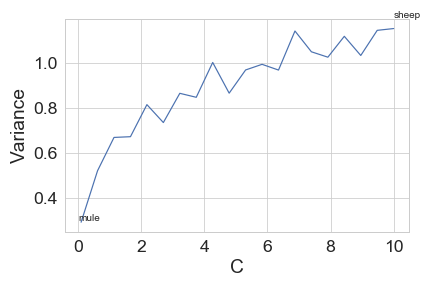

In [357]:
plt.plot(np.linspace(0.1,10,20),var)
plt.text(0,0.3,'mule')
plt.text(10,1.2,'sheep')
plt.ylabel('Variance')
plt.xlabel('C')
plt.tight_layout()